In [1]:
import pandas as pd
import numpy as np

import rasterio
import geopandas as gpd
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap
import requests


from scipy.interpolate import griddata
import tifffile as tiff
import time


In [3]:
#!pip install tifffile
#!pip install imagecodecs

In [2]:
local_filename = "col_ppp_2022_1km_UNadj.tif"


# Load the raster data
population_data_1km = rasterio.open(local_filename)

# Read the raster data
data = population_data_1km.read(1)

# Identify NoData value
nodata_value = population_data_1km.nodata

# Mask the NoData values
data = np.ma.masked_equal(data, nodata_value)

# Get coordinates
transform = population_data_1km.transform
rows, cols = data.shape

# Generate a mesh grid of indices
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

# Flatten the arrays
col_indices_flat = col_indices.flatten()
row_indices_flat = row_indices.flatten()

# Transform indices to coordinates
x_coords, y_coords = rasterio.transform.xy(transform, row_indices_flat, col_indices_flat)
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# Flatten the data array and filter out masked values
population_values_flat = data.flatten()
valid_mask = ~data.mask.flatten()

# Create a DataFrame with valid values
population_df = pd.DataFrame({
    'x': x_coords[valid_mask],
    'y': y_coords[valid_mask],
    'pop': population_values_flat[valid_mask]
})

# Display the first few rows of the DataFrame
print(population_df.head())

           x          y       pop
0 -78.555416  15.912083  0.096921
1 -78.547083  15.912083  0.007456
2 -78.555416  15.903750  0.014912
3 -79.722083  15.895417  0.074423
4 -79.738750  15.870417  0.051403


In [4]:
image_data = tiff.imread(local_filename)

# Get the dimensions of the image
height, width = image_data.shape

# Calculate the total number of pixels
total_pixels = height * width

print(f"Image Dimensions: {width} x {height}")
print(f"Total Number of Pixels: {total_pixels}")

Image Dimensions: 1796 x 2416
Total Number of Pixels: 4339136


In [39]:
# Define grid cell size
cell_size = 0.01 # Adjust the cell size as needed

# Assign each point to a grid cell
population_df['x_cell'] = (population_df['x'] // cell_size).astype(int)
population_df['y_cell'] = (population_df['y'] // cell_size).astype(int)

# Group by grid cells
grouped = population_df.groupby(['x_cell', 'y_cell'])

# Summarize the data for each region (e.g., sum population)
region_summary = grouped['pop'].sum().reset_index()
region_summary.rename(columns={'pop': 'total_pop'}, inplace=True)


In [40]:
region_summary.head()

x_cell  y_cell   total_pop
0   -8184    1216    0.532379
1   -8184    1217    0.127273
2   -8174    1247  126.415054
3   -8174    1248  442.916321
4   -8174    1249  682.592712

In [41]:
region_summary.shape

(928518, 3)

In [42]:
region_summary['total_pop'] = region_summary['total_pop']/100000

In [43]:
num_bins = 10

bins = np.linspace(region_summary['total_pop'].min(), region_summary['total_pop'].max(), num_bins + 1)
region_summary['pop_bin'] = pd.cut(region_summary['total_pop'], bins, labels=False, include_lowest=True)


In [44]:
region_summary.sample(10, random_state=10)

x_cell  y_cell     total_pop  pop_bin
256044   -7491     770  3.608949e-04        0
642509   -7162     548  1.013882e-04        0
800974   -7001     538  7.509524e-06        0
896717   -6832     612  3.551425e-05        0
643012   -7161      57  6.072183e-06        0
640924   -7163     -45  1.142488e-06        0
12563    -7793     185  5.732749e-05        0
906174   -6810     568  4.686530e-06        0
623913   -7180    -184  5.521935e-07        0
49888    -7712     670  1.401087e-05        0

In [45]:
# Define a continuous colormap with discrete segments
cmap = plt.get_cmap('YlOrBr')
norm = colors.BoundaryNorm(bins, cmap.N)

Figure and axis set up.
3D bars created.


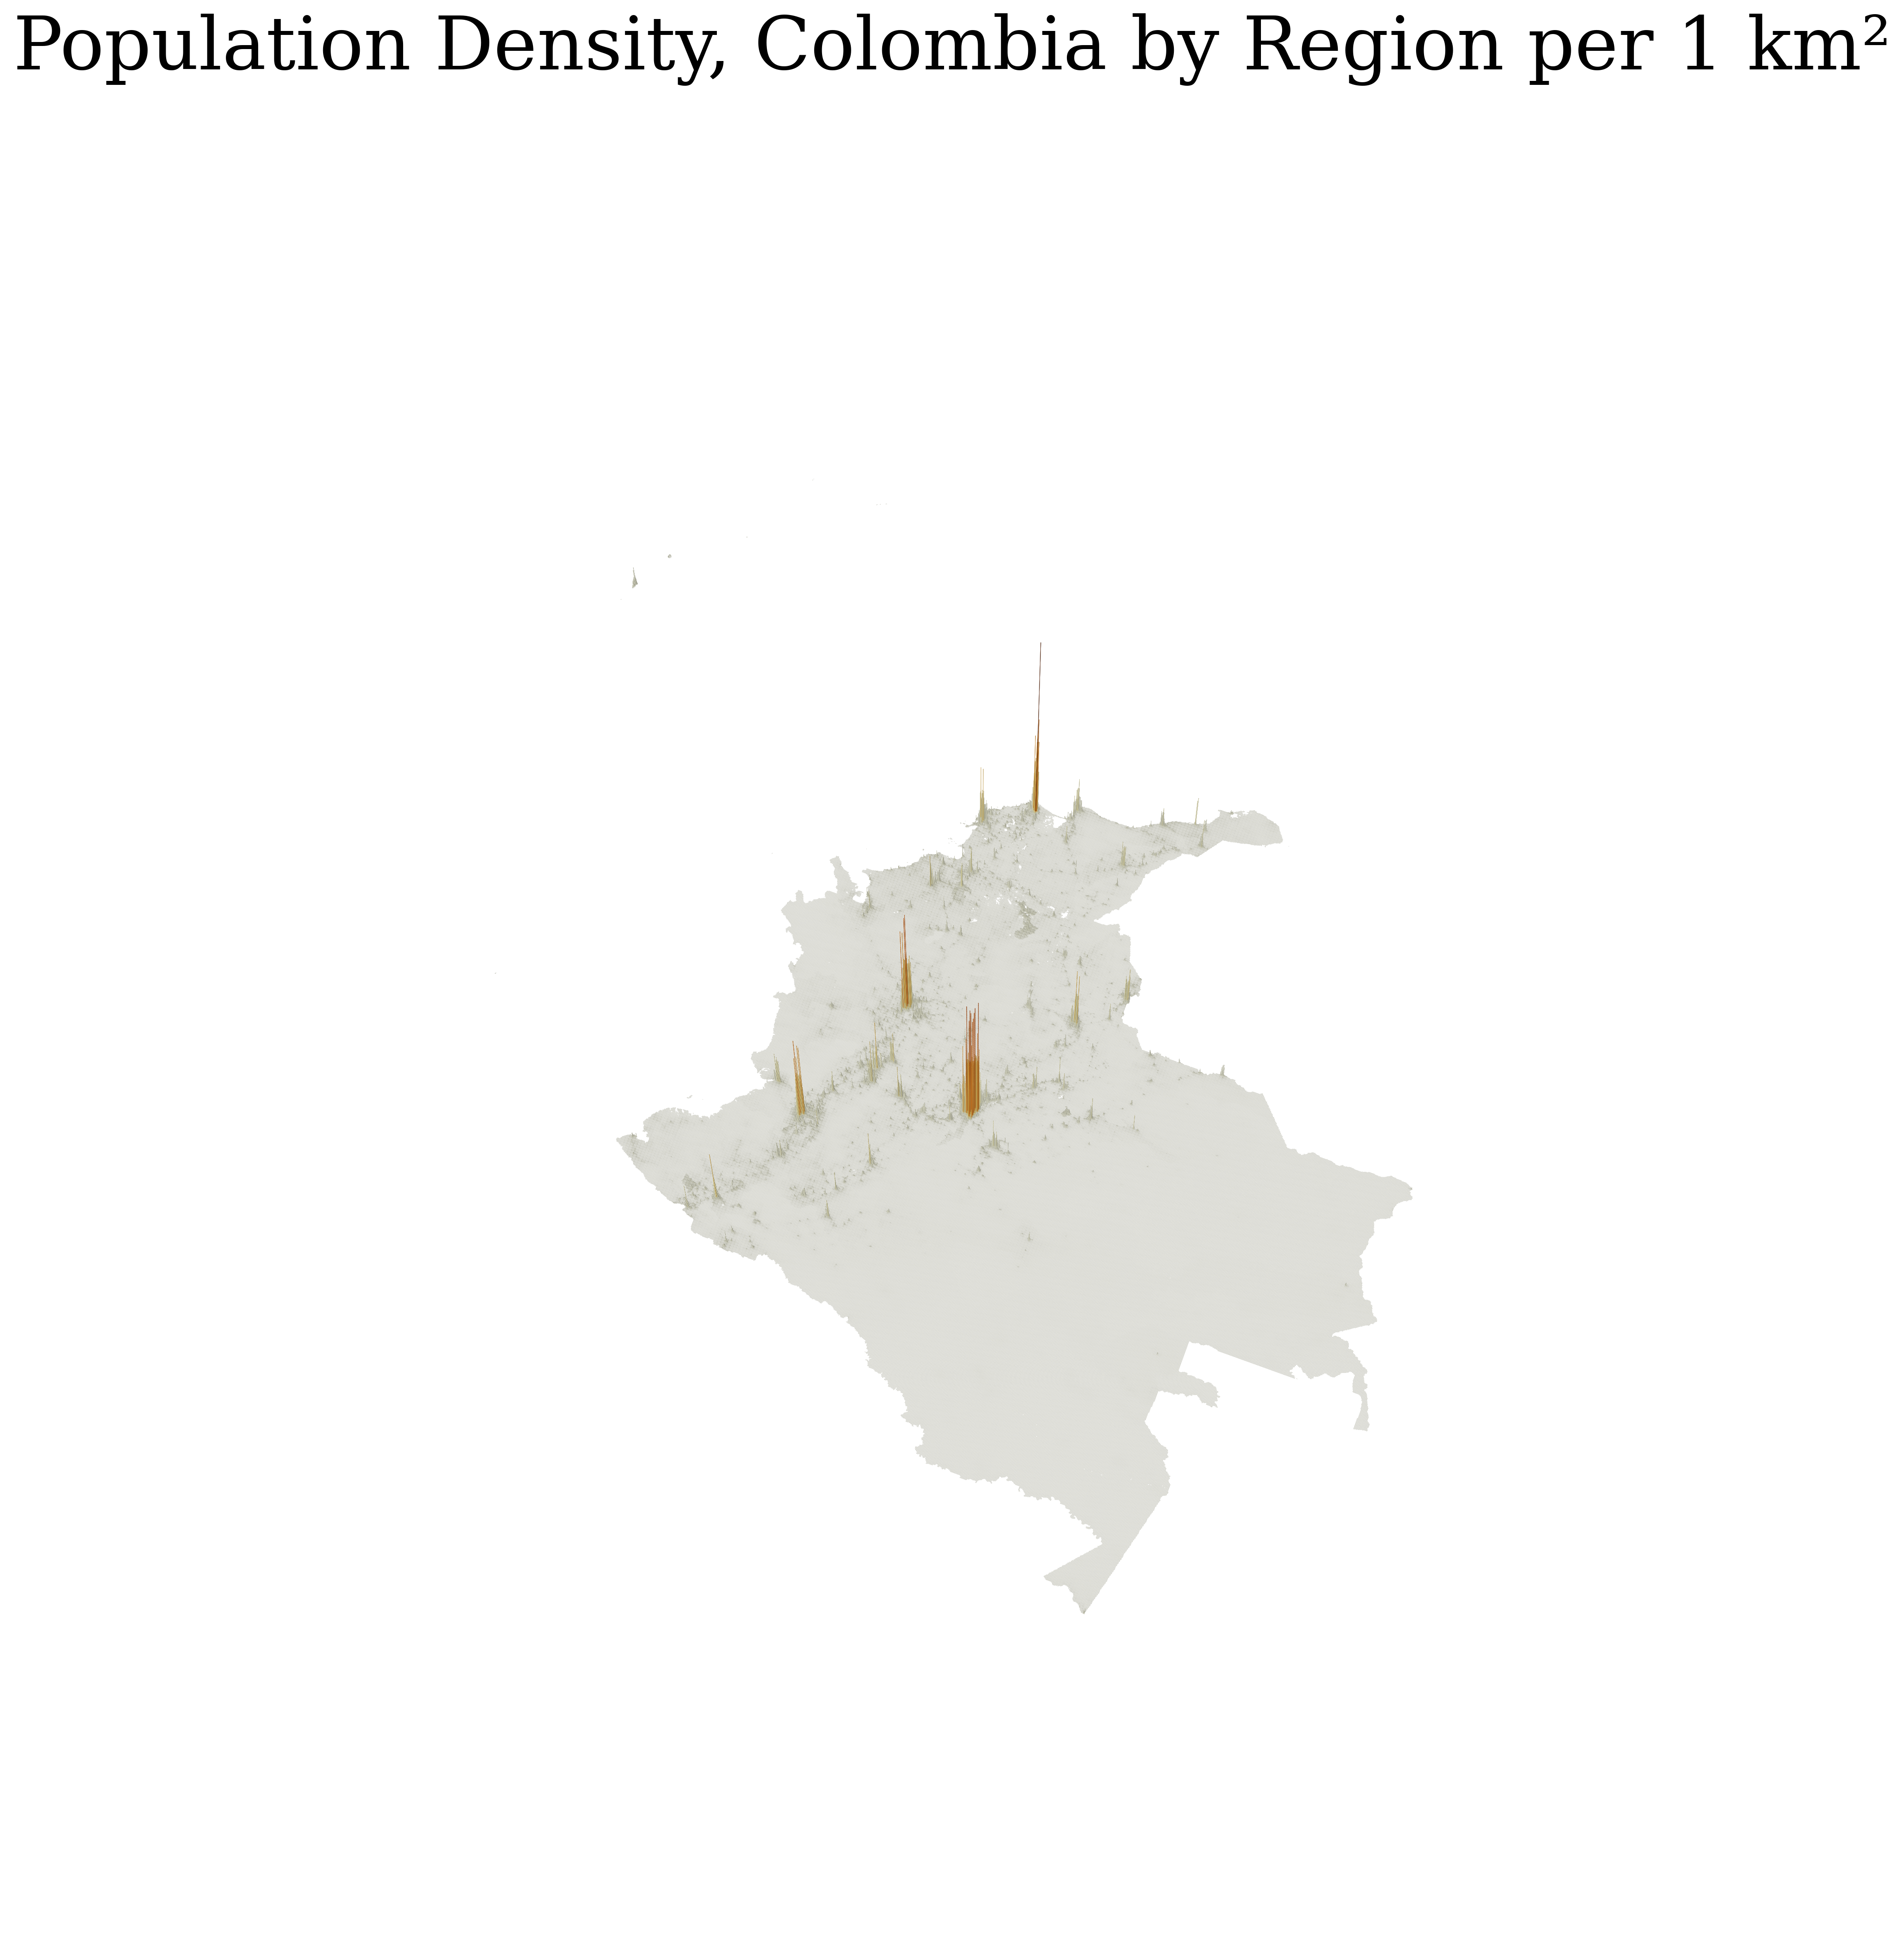

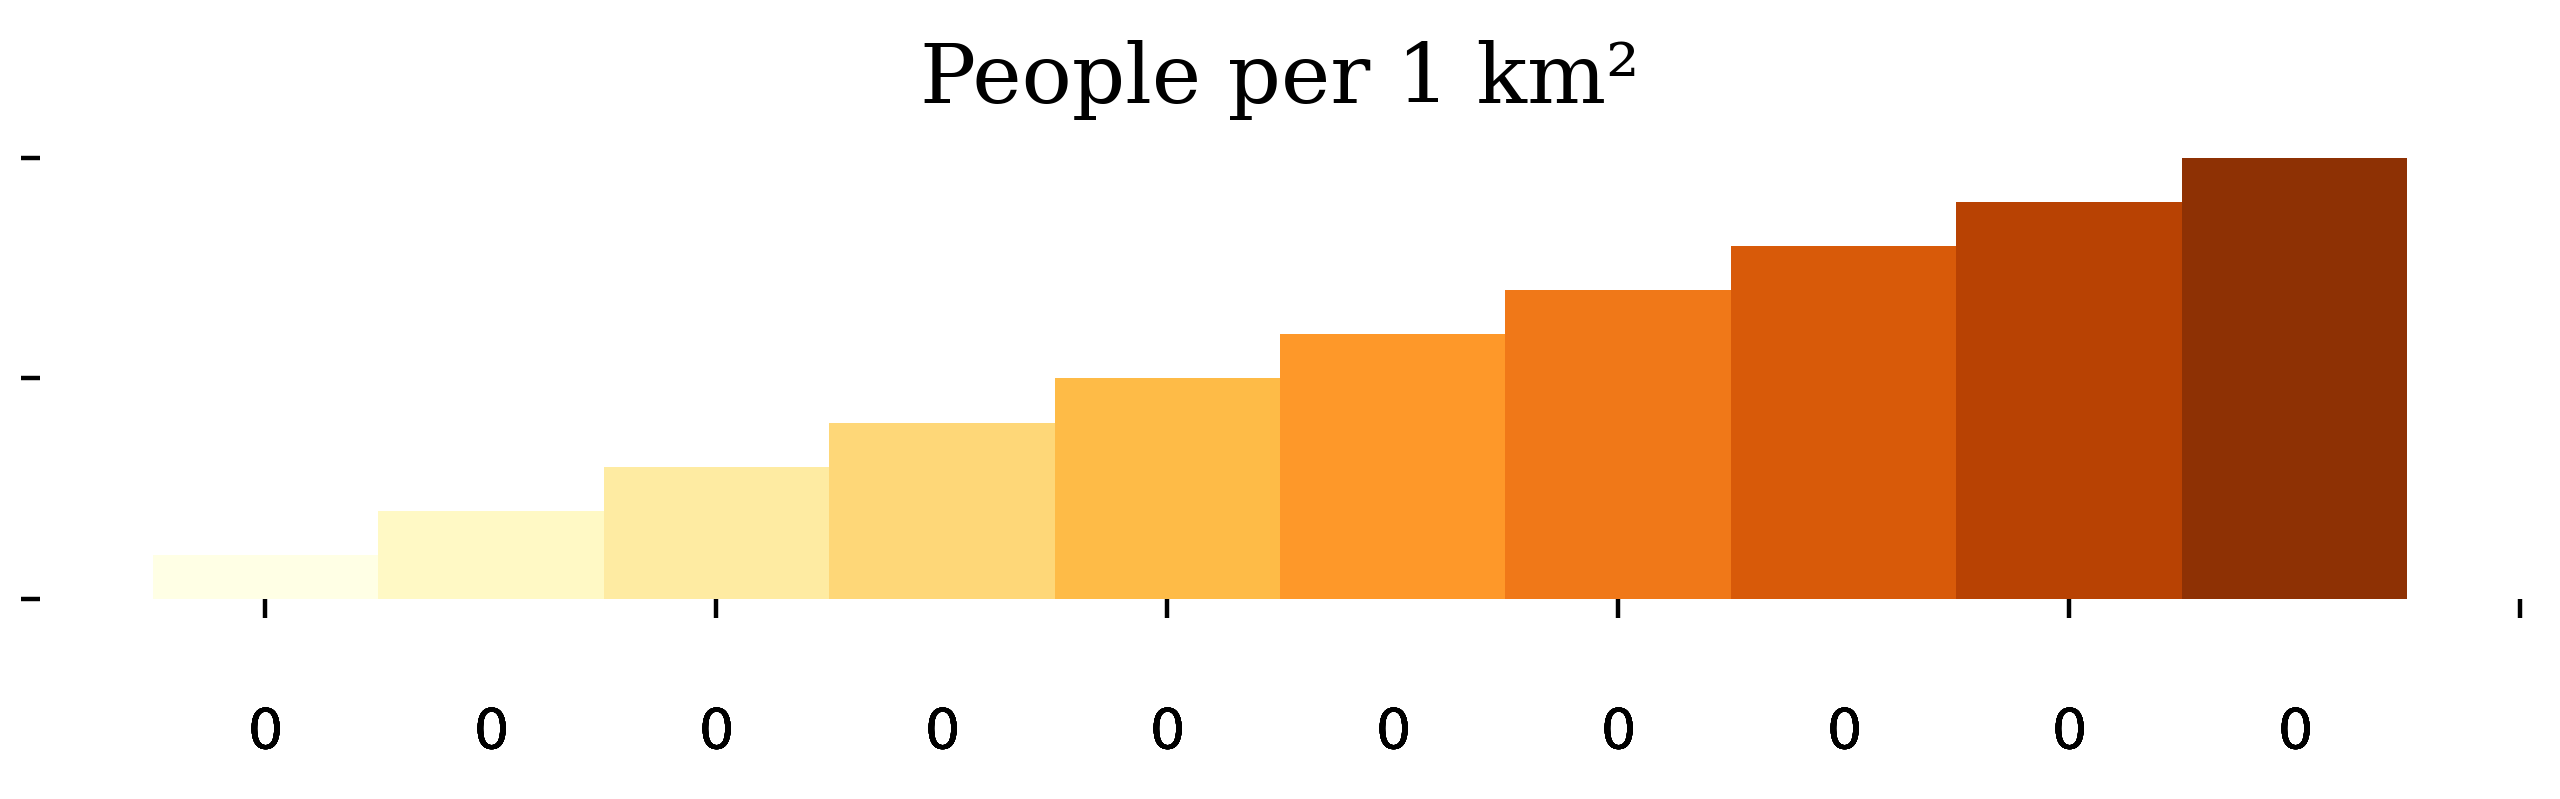

Time to create and display plot: 738.61 seconds


/var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/ipykernel_19111/2279418190.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [46]:

# Plotting
start_plot_time = time.time()

fig = plt.figure(figsize=(20, 18), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
print("Figure and axis set up.")

# Create 3D bars with color based on total population density
colors_array = cmap(norm(region_summary['total_pop']))
bars = ax.bar3d(
    region_summary['x_cell'], 
    region_summary['y_cell'], 
    np.zeros_like(region_summary['total_pop']), 
    0.45,  # Width of the bar base
    0.45,  # Depth of the bar base
    region_summary['total_pop'], 
    shade=True, 
    color = colors_array
)
print("3D bars created.")

# Remove the grid and axis panes
ax.grid(False)

# Set elevation and azimuth angles to rotate the plot to the front
ax.view_init(elev=80, azim=290)

# Set title
ax.set_title('Population Density, Colombia by Region per 1 km²', fontsize=40, fontfamily='serif')

# Create the subplot
fig_colorbar, ax_colorbar = plt.subplots(figsize=(8, 2), dpi=400)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Remove the tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Define vertices of the main triangle
main_triangle = [(0, 0), (0, 1), (1, 1)]

# Iterate over each division and create bars
for i in range(num_bins):
    for j in range(i+1):


        x = (i / num_bins)
        y = j / num_bins
        
        # Calculate the width and height of the current bar
        width = (1 / num_bins)
        height = 1 / num_bins
        
        # Plot the current bar

        ax_colorbar.bar(x,width, height,bottom=y,  color=cmap(i/num_bins))
    # Add labels
    for i in range(num_bins):
        ax_colorbar.text(i/num_bins, -0.3, f'{int(bins[i])}', ha='center', va='center')


ax_colorbar.set_title('People per 1 km²', fontsize=15, fontfamily='serif')
plt.subplots_adjust(bottom=0.3)

# Show both plots
plt.show()

# Show the plot
fig.show()
end_plot_time = time.time()
print(f"Time to create and display plot: {end_plot_time - start_plot_time:.2f} seconds")
